108.34552882262085


C:\Users\igor-\AppData\Local\Temp\ipykernel_5672\3726181539.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_n_plus_1[-1] = T1_n_plus_1


'diffusion_crank_nicolson_robin.mp4'

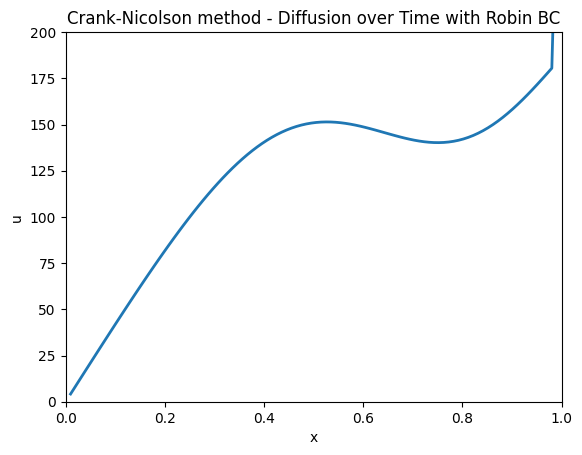

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.linalg import solve
from scipy.optimize import fsolve

# Parameters
L = 1          # Length of the domain
Nx = 100       # Number of spatial steps
dx = L / (Nx+1) # Spatial step size
alpha = 0.01       # Diffusion coefficient
dt = 0.01       # Time step size
T = 2           # Total time
Nt = int(T/dt)  # Number of time steps
r = alpha*dt/(2*dx**2)  # Stability parameter

beta = 5.6e-6      # Heat transfer coefficient
T_out = 100       # Ambient temperature
T_initial_guess = T_out  # Initial guess for temperature at x=1


# Create a figure and a line object
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

# Axis limits
ax.set_xlim((0, L))
ax.set_ylim((0, 200))

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# Construct the A and B matrices for the linear system
A = np.zeros((Nx, Nx))
B = np.zeros((Nx, Nx))
for i in range(Nx):
    for j in range(Nx):
        if i == j:
            A[i, j] = 1 + 2*r
            B[i, j] = 1 - 2*r
        elif abs(i - j) == 1:
            A[i, j] = -r
            B[i, j] = r

# Initial condition
x = np.linspace(0, L, Nx+2)
u = np.exp(-((x - L/2)**2) / (0.1*L**2))*200
print(u.mean())
u = u[1:-1]  # Exclude boundary points

def apply_robin_bc(u_n_plus_1, u_n, r, beta, dx, T_out, T_initial_guess):
    # Define the non-linear equation for the boundary condition
    def boundary_eq(T1_n_plus_1):
        return -r * T1_n_plus_1 + (1 + 2*r) * u_n[-1] - r * u_n[-2] \
               - beta * dx * (T1_n_plus_1**4 - T_out**4)
    
    # Solve for T1_n_plus_1 using fsolve with the initial guess T_initial_guess
    T1_n_plus_1 = fsolve(boundary_eq, T_initial_guess)
    
    # Update the temperature vector with the new boundary value
    u_n_plus_1[-1] = T1_n_plus_1
    
    return u_n_plus_1

# Animation function: this is called sequentially
def animate(n):
    global u
    # Solve the system A*u_new = B*u
    u_new = solve(A, B @ u)
    u_new = apply_robin_bc(u_new, u, r, beta, dx, T_out, T_initial_guess)
    u = u_new.copy()
    # Update the line data for the animation
    line.set_data(x[1:-1], u)
    return line,

# Call the animator
anim = FuncAnimation(fig, animate, init_func=init, frames=Nt, interval=50, blit=True)

plt.title('Crank-Nicolson method - Diffusion over Time with Robin BC')
plt.xlabel('x')
plt.ylabel('u')

# To save the animation, uncomment the following line
output_file_path = 'diffusion_crank_nicolson_robin.mp4'
anim.save(output_file_path, fps=30, extra_args=['-vcodec', 'libx264'])

# Return the path to the saved animation file
output_file_path
